## import các thư viện cần dùng
Bao gồm các thư viện xử lý số học như Numpy, thư viện cũng cấp các giải thuật học máy: sklearn
và thư viện tạo số ngẫu nhiên Random



In [72]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 4.5)
import logging

import numpy as np
import random
np.random.seed(42)
random.seed(42)

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve

# 12 Hàm tiếp theo tính toán các techinial indicators dùng làm features cho model random forest 
# các hàm yêu cầu truyền vào 1 dataframes và số này n để tính các chỉ số và trả về 1 data frames có thêm 1 cột là chỉ số vừa tính được.


In [35]:
def momentum(df, n):

    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


In [36]:

def rate_of_change(df, n):
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


In [37]:

def average_true_range(df, n):

    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    return df


In [38]:

def stochastic_oscillator_d(df, n):
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


In [39]:


def trix(df, n):

    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    return df


In [40]:

def macd(df, n_fast, n_slow):

    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


In [41]:

def vortex_indicator(df, n):
    i = 0
    TR = [0]
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    return df


In [42]:

def relative_strength_index(df, n):
   
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df


In [43]:
def true_strength_index(df, r, s):

    M = pd.Series(df['Close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


In [44]:

def accumulation_distribution(df, n):
 
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df



In [45]:

def money_flow_index(df, n):
    
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    return df


In [46]:

def on_balance_volume(df, n):

    i = 0
    OBV = [0]
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    return df


In [47]:

def ease_of_movement(df, n):

    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


In [48]:

def commodity_channel_index(df, n):

    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


# khối lệnh này đọc vào tập tin csv chứa thông tin lịch sử giá cổ phiếu, bao gồm Ngày, Giá mở cửa phiên giao dịch, giá đóng cửa, giá cao nhất, giá thấp nhất,...
# và xóa bỏ bớt các cột không cần thiết

In [76]:
aapl = pd.read_csv('msft.csv')
del (aapl['Date'])
del (aapl['Adj Close'])
aapl.head()



,Open,High,Low,Close,Volume
0,37.96,38.01,37.43,37.50,60437400
1,37.24,38.22,37.06,38.18,88615100
2,35.79,36.71,35.77,36.64,51646300
3,35.59,35.98,35.55,35.94,28060700
4,35.67,35.69,35.39,35.53,40264600


# Hàm này dùng để làm mịn dữ liệu chỉ số alpha dùng để biết độ "mịn"

In [50]:

def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()
    return edata


# Hàm head dùng để show ra 5 records đầu tiên của dataframes 

In [51]:

saapl = get_exp_preprocessing(aapl)
saapl.head()  # saapl stands for smoothed aapl


,Open,High,Low,Close,Volume
0,37.960000,38.010000,37.430000,37.500000,6.043740e+07
1,37.305455,38.200909,37.093636,38.118182,8.605349e+07
2,35.940180,36.857748,35.901171,36.786486,5.505602e+07
3,35.624986,36.067696,35.585086,36.024572,3.075780e+07
4,35.665499,35.727766,35.409507,35.579453,3.931401e+07


# Đây là một hàm quan trọng, dùng để sử dụng các hàm tính các technical indicators ở trên để tạo ra một dataframes có đủ các freature, các giá trị [5, 14, 26, 44, 66] là số ngày trong quá khứ. mỗi lần gọi hàm, data frame lại có thêm 1 cột.

In [53]:

def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = relative_strength_index(data, n=x)
        data = stochastic_oscillator_d(data, n=x)
        data = accumulation_distribution(data, n=x)
        data = average_true_range(data, n=x)
        data = momentum(data, n=x)
        data = money_flow_index(data, n=x)
        data = rate_of_change(data, n=x)
        data = on_balance_volume(data, n=x)
        data = commodity_channel_index(data, n=x)
        data = ease_of_movement(data, n=x)
        data = trix(data, n=x)
        data = vortex_indicator(data, n=x)

    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Williams %R is missing
    data = macd(data, n_fast=12, n_slow=26)

    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])

    return data


In [54]:

def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)


def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del (data['Close'])
    return data.dropna()


# Gọi hàm và hiển thị dữ liệu mẫu


In [55]:

data = prepare_data(saapl, 10)

y = data['pred']

# remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]

data.head()

,RSI_5,SO%d_5,Acc/Dist_ROC_5,ATR_5,Momentum_5,MFI_5,ROC_5,OBV_5,CCI_5,EoM_5,...,Trix_66,Vortex_66,ema50,ema21,ema14,ema5,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,pred
196,0.741879,0.306430,7.111157,0.565174,0.477301,0.8,0.012029,7.039205e+06,1.269440,1.120196e-09,...,-0.001429,-0.285394,0.933565,0.982942,0.996321,1.005449,-0.182822,-0.231482,0.048660,0.0
197,0.549188,0.445906,-1.502326,0.550562,0.506730,0.8,0.019897,9.586273e+06,0.939444,7.722063e-10,...,-0.001436,-0.277104,0.940615,0.989653,1.002454,1.009827,-0.143733,-0.213933,0.070199,0.0
198,0.652886,0.418492,-1.759663,0.525419,0.473673,0.8,0.001313,8.338596e+06,0.885058,4.950498e-10,...,-0.001442,-0.248732,0.939344,0.987673,0.999870,1.006005,-0.117245,-0.194595,0.077350,0.0
199,0.286965,0.469109,-1.304510,0.618117,0.002367,0.6,0.014209,-1.848412e+07,-0.030381,9.486746e-12,...,-0.001447,-0.256093,0.939352,0.987070,0.998734,1.003973,-0.097887,-0.175254,0.077366,0.0
200,0.286965,0.414740,0.454623,0.618862,0.162237,0.6,-0.005714,-2.818734e+07,-1.575528,1.537685e-10,...,-0.001452,-0.253063,0.932931,0.979920,0.991177,0.996455,-0.099827,-0.160168,0.060341,0.0


# Hai khối lệnh típ theo dùng để phân chia tập traning và testing tập traning = 2/3 tập features tuy nhiên việc phân chia này không ngẫu nhiên, tức là 2/3 dữ liệu đầu tiên dùng làm tập training, và phần còn lại dùng làm dữ liệu testing 

In [56]:
train_size = 2 * len(X) // 3

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# In[121]:

In [57]:
print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))


len X_train 4506
len y_train 4506
len X_test 2253
len y_test 2253


# Tạo ra 1 random forest với 65 cây quyết định, khởi tạo radom (seed = 42) và n_jobs = -1 có nghĩa là sử dụng tất cả các processors của máy tính để học.

In [58]:

rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());


# Đánh giá mô hình qua các giá trị precision, recall, f1, accuracy
# Kết quả ở dưới thể hiện 1 điều là khi chúng ta chia dữ liệu không random, kết quả tạo ra có độ chính xác không cao. 

In [59]:
pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.42, recall: 0.51, f1: 0.46, accuracy: 0.51
Confusion Matrix
[[682 648]
 [449 474]]


# Các biểu đồ thể hiện lần lượt giá trị dự đoán và thực tế, phân bố xác xuất của kết quả dự đoán và thực tế.

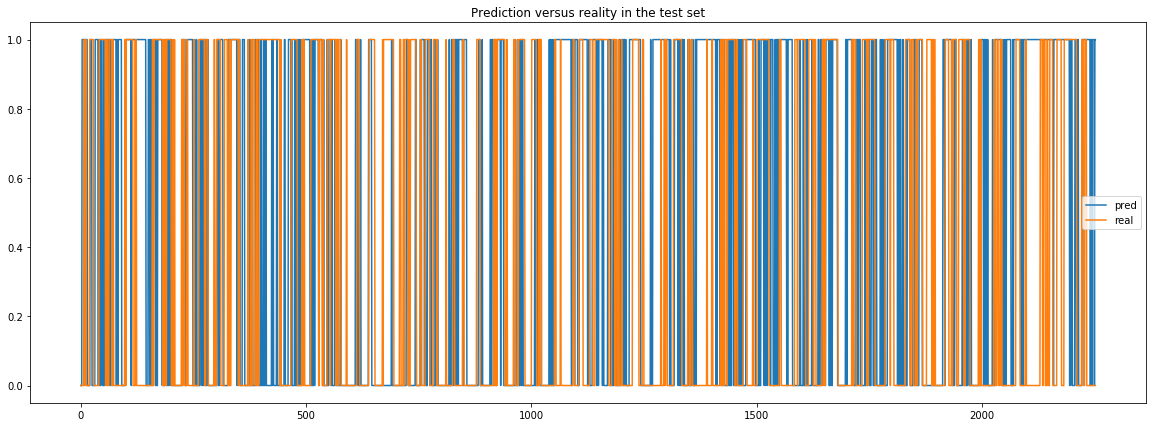

In [60]:

plt.figure(figsize=(20, 7))
plt.plot(np.arange(len(pred)), pred, label='pred')
plt.plot(np.arange(len(y_test)), y_test, label='real');
plt.title('Prediction versus reality in the test set')
plt.legend();


<Figure size 1440x504 with 0 Axes>

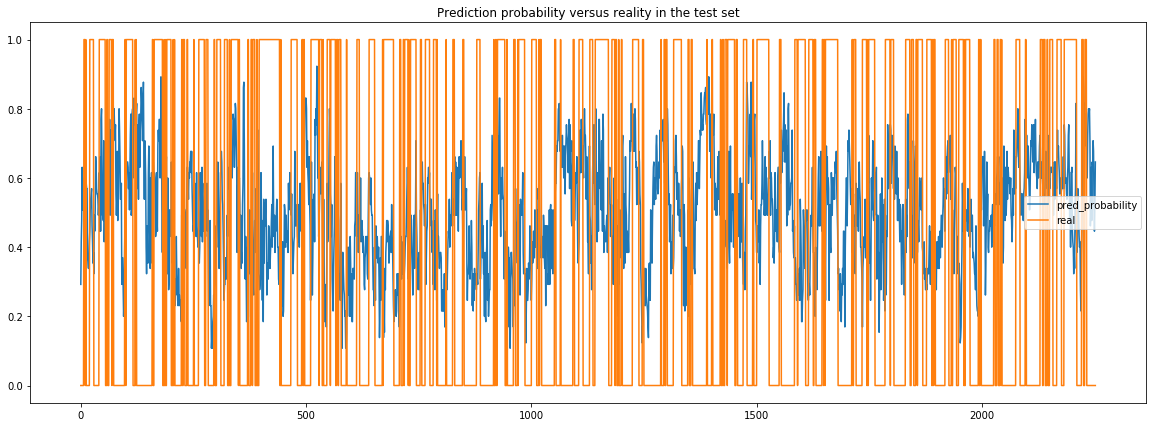

In [61]:



plt.figure(figsize=(20, 7))
proba = rf.predict_proba(X_test)[:, 1]
plt.figure(figsize=(20, 7))
plt.plot(np.arange(len(proba)), proba, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, label='real');
plt.title('Prediction probability versus reality in the test set');
plt.legend();
plt.show();


# Thử tạo lại random forest lần này sử dụng hàm phân chia random train_test_split

In [62]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2 * len(X) // 3)

print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))


len X_train 4506
len y_train 4506
len X_test 2253
len y_test 2253


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [63]:

rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

# Kết quả cho thấy độ chính xác tăng từ 50% lên 80%. Điều này cho thấy rằng RF phụ thu

In [64]:

pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)


precision: 0.82, recall: 0.73, f1: 0.77, accuracy: 0.80
Confusion Matrix
[[1019  169]
 [ 290  775]]


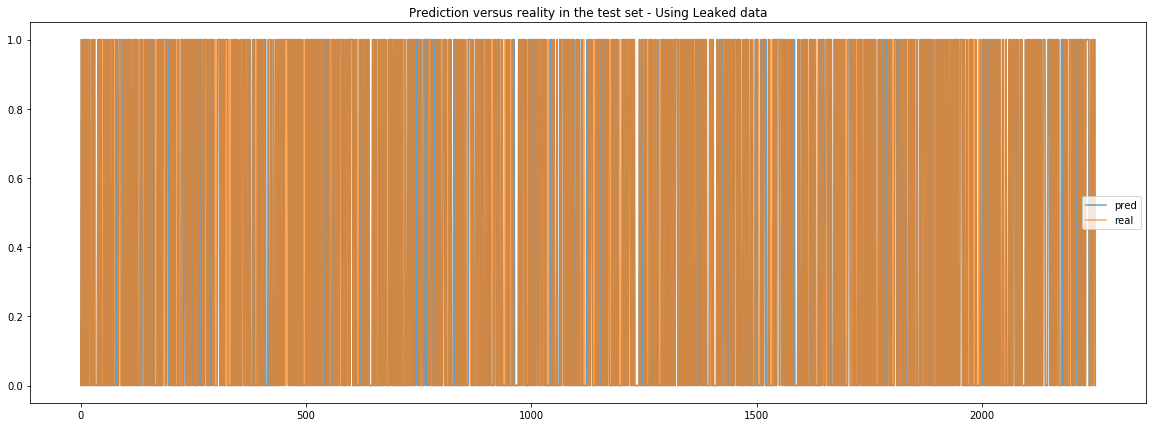

In [65]:

plt.figure(figsize=(20, 7))
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real');
plt.title('Prediction versus reality in the test set - Using Leaked data')
plt.legend();

# In[ ]:


# In[86]:


<Figure size 1440x504 with 0 Axes>

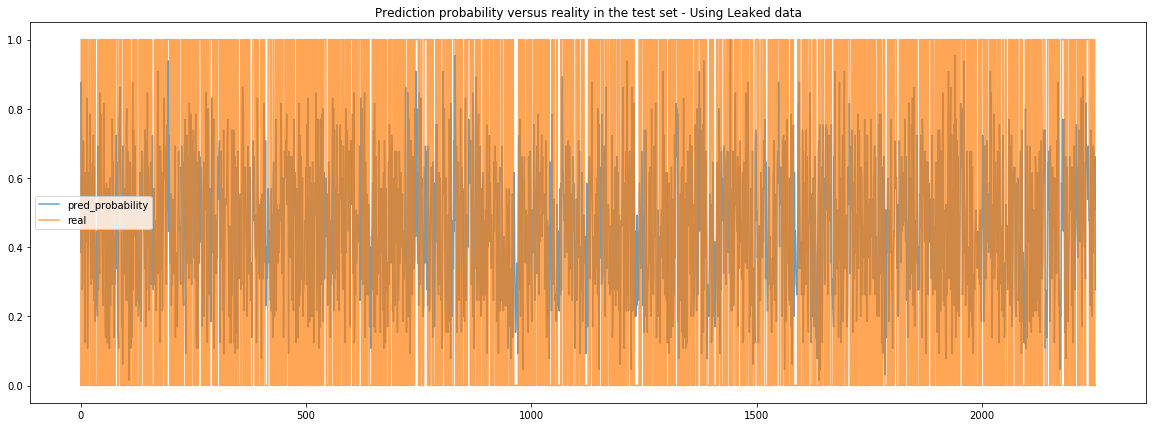

In [66]:



plt.figure(figsize=(20, 7))
proba = rf.predict_proba(X_test)[:, 1]
plt.figure(figsize=(20, 7))
plt.plot(np.arange(len(proba)), proba, alpha=0.7, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real');
plt.title('Prediction probability versus reality in the test set - Using Leaked data');
plt.legend();
plt.show();


In [73]:
def ROC_Curve(rf, auc):
    y_predicted = rf.predict_proba(X_test)[:, 1]
    false_positive, true_positive, _ = roc_curve(y_test, y_predicted)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc)
    plt.legend(loc='best')
    plt.show()


auc = roc_auc_score(y_test, pred)



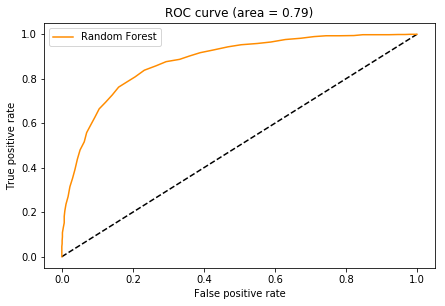

In [74]:
ROC_Curve(rf, auc)